# Relaciones semánticas con Word Embeddings
Anteriormente se ha visto cómo se puede calcular la similitud entre textos a través de la comparación e identificando tokens comunes entre ellos, pero es muy posible que debido a la complejidad del lenguaje, dos textos tengan un significado similar sin tener en común ninguna palabra.

En este apartado se introducirá el uso de word embeddings para analizar e identificar relaciones semánticas entre palabras para mejorar tareas como la clasificación de textos, la búsqueda de información o la generación de contenido.

En este caso, se explorará el uso de embeddings de palabras para analizar relaciones semánticas en textos extraídos de comentarios de usuarios de un repositorio de Github, "zigbee2mqtt". El estudio se centrará en la identificación de patrones y similutes en las discusiones sobre dispositivos IoT.

A través de modelos preentrenados y técnicas de entrenamiento personalizados, se examinará como los embeddings pueden mejorar el análisis semántico.

Se hará uso de la librería *Gensim*, ya conocida y utilizada en los apartados anteriores, para entrenar y utilizar los modelos de embeddings. Gensim proporciona una API eficiente para trabajar con embeddings como Word2Vec, FastText y GloVe, falicitando la implementación de consultas semánticas y visualización de relaciones entre términos.

## ¿Qué es ***embedding***?
Un *embedding* es una representación numérica de un objeto (palabra, frase, etc) en un espacio vectorial de menos dimensión. Se debe diferenciar entre word embedding y documento embedding. *Word embedding* es una representación vectorial de una única palabra, mientras que *document embedding* es una representación vectorial de un documento, es decir, una secuencia de palabras de cualquier longitud estrictamente mayor a 1. 

En este apartado únicamente se trabajará con **word embeddings**.

## Word Embeddings
El objetivo de un algoritmo de *embedding* es encontrar representaciones vectoriales de palabras en un espacio de dimensión *d*, de forma que palabras con significados similares tengan vectores similares. La dimensión *d* es un hiperparámetro del modelo, generalmente establecido entre 50 y 300.

Estas dimensiones no tienen un significado predefinido o interpretable, es el modelo el encargado de aprender relaciones latentes entre las palabras presentes en el texto. Cada dimensión representa una posible relación entre palabras, permitiendo que términos similares tengan valores parecidos en ciertas dimensiones.

Tras esta explicación, se podría decir que la idea básica del entrenamiento es: las palabras que aparecen en contextos similares tienen significados similares. A esto se le denomina *hipótesis distribucional* (distributional hypothesis).

## Tipos de *Embeddings*
Se han desarrollado numerosos algoritmos para entrenar word embeddings. Como en esta ocasión se utilizará la librería de Gensim nos centraremos en dos algoritmos: Word2Vec y FastText

### Word2Vec
Existen dos variantes de este algoritmo: *continuous bag-of-words model (CBOW)* y *skip-gram model*.

El modelo **CBOW** predice una palabra objetivo basándose en su contexto (las palabras que se encuentran a su alrededor). Es más eficiente en la etapa de entrenamiento porque usa promedios de los vectores de las palabras del contexto para hacer las predicciones.

La modelo **skip-gram model** predice el contexto de una palabra objetivo, es decir, trata de averiguar qué palabras rodearían a una palabra dada. Este requiere más tiempo de entrenamiento pero ofrece mejores resultados a la hora de capturar relaciones entre palabras poco frecuentes.

### GloVe
**GloVe** (global vectors) es capaz de aprender representaciones vectoriales de palabras basándose en la coocurrencia global dentro de un corpus de texto. En lugar de predecir palabras a partir de su contexto inmediato, construye una matriz que captura cuántas veces aparecen juntas las palabras y luego aplica factorización para reducir su dimensionalidad, obteniendo vectores densos donde palabras con significados similares están cerca en el espacio vectorial, permitiendo capturar mejor las relaciones semánticas y mejorar las tareas como la detección de analogías.

## Uso de *Similarity Queries* (consultas de similitud) en modelos preentrenados
Las consultas de similitud son consultas que permiten encontrar palabras, frases o documentos similares dentro de un modelo de embeddings o espacio vectorial. Se basan en métricas como la similitud del coseno, que mide qué tan cercanos se encuentran dos vectores en el espacio.

Para este primer acercamiento se utilizarán embeddings preentrenados, permitiendo ahorrar mucho tiempo.

### Pasos previos
Antes de nada, se debe cargar la configuración para la ejecución de python al igual que se ha venido haciendo en todos los apartados anteriores.

Ahora se va a hacer uso del directorio *packages* que ha sido obtenido del repositorio del libro que se está utilizando como referencia para el desarrollo del proyecto.

In [ ]:
import sys, os

#Carga del archivo setup.py
%run -i ../pyenv_settings/setup.py

#Imports y configuraciones de gráficas
%run "$BASE_DIR/pyenv_settings/settings.py"

%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'png'

#Establece la precisión para los valores de similitud
%precision 3 
np.set_printoptions(suppress=True) #No científico para valores pequeños

You are working on a local system.
Files will be searched relative to "..".


In [39]:

#Ruta para importar los paquetes (necesario)
sys.path.append(os.path.join(BASE_DIR, 'packages'))

### Carga del modelo preentrenado
Para cargar el modelo se utilizará la API de descarga de Gensim. Por defecto, los modelos se almacenan en la ruta *~/gensim-data*, si se desea cambiar el lugar de almacenamiento se debe modificar la ruta antes de importar la API. En este caso, yo voy a mantener la predefinida.

In [3]:
import gensim.downloader as api
import gensim

#gensim.models.utils.DEFAULT_DATADIR = os.path.join('$BASE_DIR', 'models')

Se ha hecho uso de *pandas* para mostrar los resultados en un DataFrame para visualizarlos de forma más clara en forma de lista.

In [4]:
info_df = pd.DataFrame.from_dict(api.info()['models'], orient='index')
info_df[['file_size', 'base_dataset', 'parameters']].head(5)

,file_size,base_dataset,parameters
fasttext-wiki-news-subwords-300,1005007116.00,"Wikipedia 2017, UMBC webbase corpus and statmt.org news dataset (16B tokens)",{'dimension': 300}
conceptnet-numberbatch-17-06-300,1225497562.00,"ConceptNet, word2vec, GloVe, and OpenSubtitles 2016",{'dimension': 300}
word2vec-ruscorpora-300,208427381.00,Russian National Corpus (about 250M words),"{'dimension': 300, 'window_size': 10}"
word2vec-google-news-300,1743563840.00,Google News (about 100 billion words),{'dimension': 300}
glove-wiki-gigaword-50,69182535.00,"Wikipedia 2014 + Gigaword 5 (6B tokens, uncased)",{'dimension': 50}


Se utilizará el modelo *glove-wiki-gigaword-50*. Este modelo con vectores de palabras de 50 dimensiones, y entrenado con unas 6.000 millones de palabras minúsculas, es de dimensiones reducidas pero suficiente para lo que se desea hacer en estos momentos.

El modelo se descarga del siguiente modo:

In [5]:
model = api.load('glove-wiki-gigaword-50')

El modelo pesa únicamente 66 MB. Su reducido peso se debe a que no contiene un modelo GloVe completo, únicamente los vectores de palabras. En caso de tener interés en ampliar el entrenamiento, modelos tan reducidos como este no pueden porque no se incluyen los estados internos.

### Consultas de similitud
Se puede acceder al vector de una palabra, por ejemplo *king*, por medio de la función *model.wv['king']*, o de forma aún más sencilla, con *model['king']*

In [7]:
%precision 2 

v_king = model['king']
v_queen = model['queen']

print("Vector size:", model.vector_size)
print("v_king  =", v_king[:10])
print("v_queen =", v_queen[:10])

Vector size: 50
v_king  = [ 0.5   0.69 -0.6  -0.02  0.6  -0.13 -0.09  0.47 -0.62 -0.31]
v_queen = [ 0.38  1.82 -1.26 -0.1   0.36  0.6  -0.18  0.84 -0.06 -0.76]


Tras mostrar los primeros 10 elementos del vector de cada palabra, también se puente imprimir la similitud entre ambas palabras según el modelo.

In [8]:
print("similarity:", model.similarity('king', 'queen'))

similarity: 0.7839043


Como era de esperar, ambas palabras cuentan con una similitud relativamente alta.

De todos modos, se pueden comprobar cuáles son las palabras con más similitud a otra y así saber si *queen* es la palabra más similar a *king*

In [9]:
%precision 3

model.most_similar('king', topn=3)

[('prince', 0.824), ('queen', 0.784), ('ii', 0.775)]

*Prince* es la palabra más similar a *king* y *queen* es la segunda más similar.

Las puntuaciones (porcentajes) de similitud en los vectores de palabras están principalmente computadas mediante la similitud del coseno. Por ejemplo, la función *cosine_similarities* calcula la similitud entre un vector de palabra y un arrary de otros vectores de palabras.

In [10]:
v_lion = model['lion']
v_nano = model['nanotechnology']

model.cosine_similarities(v_king, [v_queen, v_lion, v_nano])

array([ 0.784,  0.478, -0.255], dtype=float32)

En base a los resultados obtenidos, se entiende que *king* es bastante similar a *queen*, hay algunas similitudes con *lion*, y no se parece en nada a *nanotechnology*. Como se ve, algunas dimensiones pueden llegar a ser negativas, pues el rango de valores de similitud va desde -1 a 1.

La función *most_similar* vista antes también acepta los parámetros *positive* y *negative*.

Resumiendo, en el parámetro *positive* se incluyen las palabras sobre las cuáles se quieren buscar las palabras más similares entre las dos, y en *negative* aquellas palabras que quieres que se eviten en las similitudes.

In [11]:
model.most_similar(positive=['paris', 'germany'], negative=['france'], topn=3)

[('berlin', 0.920), ('frankfurt', 0.820), ('vienna', 0.818)]

En este caso por ejemplo vemos que se desean buscar las similitudes entre *paris* y *germany*, pero que no se incluyan las que se tienen con *france*. Entonces los resultados muestran: berlin, frankfurt y vienna. Se puede deducir que las similitudes se han obtenido a partir de que *paris* es la capital/ciudad más importe de Francia, y las similitudes que ha encontrado el modelo son ciudades importantes de Alemania, Berlín (capital) y Frankfurt, o capitales europeas cercanas a Alemania, como es Vienna.

In [12]:
model.most_similar(positive=['france', 'capital'], topn=1)

[('paris', 0.784)]

Si se entrenan este tipo de modelos con comentarios generados por usuarios obtenidos de redes sociales, este aprenderá relaciones entre palabras en base a estas discusiones. De este modo, se convierte en una representación de la relación que la gente cree que existe, independientemente de que exista o no.

Es un efecto secundario interesante que se tratará en el apartado a continuación.

## Entrenamiento y evaluación de un modelo de Embedding
Antes de comenzar con el entrenamiento, hay que preparar adecuadamente los datos con los que se entrenará el modelo. Estos pasos previos pueden tener un gran impacto sobre la eficacia del modelo para tareas específicas.

### Preparación de los datos
Gensim requiere de secuencias de tokens como entrada para el entrenamiento. También hay otros aspectos que se deben tener en cuenta a la hora de la preparación de los datos.

Basándose en la hipótesis distribucional, las palabras que habitualmente aparecen juntas o en un mismo contexto tendrán unos vectores parecidos, por ello hay que asegurarse de que las coocurrencias son realmente identificadas como tal.

A la hora de la preparación es aconsejable seguir los siguientes pasos: 
- *Limpieza del texto de tokens no deseados.* Este paso ya se realizó previamente en el notebook *c_preparing_data_for_statistics_and_ML.ipynb*. 
- *Poner todas las palabras en minúsculas*. Se realiza de forma muy sencilla tras cargar las tablas necesarias para el entrenamiento en el DataFrame desde la base de datos. 
- *Uso de lemmas*. En el notebook *d_PNL_spaCy.ipynb* ya se mostró, y se realizó, el proceso para la extracción de lemas basados en partes del discurso para luego ser guardados en la base de datos. Cargaremos a continuación también la tabla de lemas en el DataFrame.

In [13]:
#Conexión con la base de datos en la que tenemos guardado el Data Frame
db_name = "../data/zigbee2mqtt_comments.db"
con = sqlite3.connect(db_name)
df = pd.read_sql("select normalized_text, tokens, lemmas from posts_nlp", con)
con.close()

#Comprobación de que se ha cargado correctamente
print(df.columns)

Index(['normalized_text', 'tokens', 'lemmas'], dtype='object')


Tras cargar las tablas en el DataFrame se transformarán todas las palabras a minúscula (es posible que ya lo estuviesen, pero es mejor asegurarse y no conlleva un gasto computacional nada elevado).

In [14]:
#Todas las tablas a minúsculas
df['normalized_text'] = df['normalized_text'].str.lower().str.split()
df['tokens'] = df['tokens'].str.lower().str.split()
df['lemmas'] = df['lemmas'].str.lower().str.split()

#Setencias para el entrenamiento
sents = df['lemmas']

print(df['normalized_text'].sample(5))
print(df['tokens'].sample(5))
print(df['lemmas'].sample(5))

431                                                    [switching, to, the, dev/edge, addon, unfortunately, did, not, solve, this, issue., i'll, try, switching, to, an, older, version, if, that's, possible.]
2082                                                                                                                                                                                            [yes,, thanks!]
512                                  [i, have, the, same, issue, after, updating., ram, usage, increases, until, it, eventually, crashes., !screenshot_2024-03-08-21-46-17-08_c3a231c25ed346e59462e84656a70e50]
1920                                                                                                                                                                        [see, home-assistant, /core/#67875]
1713    [@koenkk, yea, ok, i, think, i, misunderstood, the, directions., i, targetted, the, dev, branch, because, technically, this, pr, had, a, fix, for, stable, in, i

#### Frases
El siginificado de una palabra puede cambiar si esta es parte de una frase compuesta (palabra compuesta, como *add on* o *core 2021.3.1*), especialmente en inglés que es el idioma principal sobre el que se trabaja. Por lo tanto, sería mejor entender estas palabras como un único token.

Existen muchos algoritmos para detectar este tipo de frases y la gran mayoría ofrecen un gran desempeño. En este caso, se utilizará una versión avanzada del algoritmo *pointwise mutual information (PMI)*, cuyo funcionamiento se basa básicamente en medir la dependencia estadística entre las ocurrencias de dos palabras , denominada *normalized pointwise mutual information (NPMI)*.  En un principio el valor del umbral utilizado puede ser reducido, de 0.3, lo que puede dar lugar a frases (un único token) que en realidad no son compuestas por dos palabras, si no que por casualidad aparecen juntas con cierta frecuencia. Para evitar errores de este tipo, se establecerá el umbral en 0.5, un valor intermedio. Además, hay se establecerá el guión (-) como delimitador entre dos palabras para formar una compuesta, generando nuevos tokens compuestos de otros dos tokens. 

In [15]:
from gensim.models.phrases import Phrases, npmi_scorer
import gensim

#Establece el delimitador dependiendo de la versión de gensim
if gensim.__version__[0] > '3': # gensim 4.x string delimiter
    delim = '-'
else: # gensim 3.x - byte delimiter
    delim = b'-'

phrases = Phrases(sents, min_count=10, threshold=0.5, 
                  delimiter=delim, scoring=npmi_scorer)

Veamos si con este modelo se pueden identificar frases de este tipo:

In [16]:
sent = "This add on is well-suited for my environment based on core-2021.3.1".split()
phrased = phrases[sent]
print('|'.join(phrased))

This|add-on|is|well-suited|for|my|environment|based|on|core-2021.3.1


A continuación, se exportarán todas las frases encontradas en el corpus junto con sus puntuaciones y se convertirán los resultados a un DataFrame para mejor la inspección de los datos, eliminando las frases duplicadas y ordenándose en base a su puntuación.

In [17]:
#Compatibilidades con las versiones de Gensim
if gensim.__version__[0] > '3': # gensim 4.x - find_phrases / string phrases

    phrase_df = pd.DataFrame(phrases.find_phrases(sents), 
                             columns =['phrase', 'score'])
    phrase_df = pd.DataFrame.from_dict(phrases.find_phrases(sents), orient='index').reset_index()
    phrase_df.columns = ['phrase', 'score']
    phrase_df = phrase_df[['phrase', 'score']].drop_duplicates() \
            .sort_values(by='score', ascending=False).reset_index(drop=True)

else: # gensim 3.x - export_phrases / byte phrases
    phrase_df = pd.DataFrame(phrases.export_phrases(sents, out_delimiter=delim), 
                             columns =['phrase', 'score'])
    phrase_df = phrase_df[['phrase', 'score']].drop_duplicates() \
        .sort_values(by='score', ascending=False).reset_index(drop=True)
    phrase_df['phrase'] = phrase_df['phrase'].map(lambda p: p.decode('utf-8'))

Como habíamos escogido un valor intermedio para el umbral (0.5), podemos comprobar si se cumplen las expectativas y en base a esto variarse para un mejor desempeño.

In [18]:
phrase_df

,phrase,score
0,zigbee-herdsman,1.91
1,ttyz2m-mode=777,1.00
2,nodelay-reuseaddr,1.00
3,"reuseaddr-keepidle=1,keepintvl=1,keepcnt=5",1.00
4,pci0000:00/0000:00:11.0/0000:02:05.0-ata1,1.00
...,...,...
614,08:06:48-info,0.50
615,as-expect,0.50
616,to-1.42.0,0.50
617,late-version,0.50


Se observa que la puntuación más baja es 0.5 y la más alta de 1.91, seguida de 1.0. Ignorando la frase con puntuación 1.91 (la diferencia con el siguiente valor más alto es demasiado elevada), se debería establecer un valor entre 0.5 y 1.0 para obtener una mayor eficacia, por ejemplo 0.9.

In [19]:
logging.getLogger().setLevel(logging.WARNING) ###

sents = df['lemmas'] #Lemas originales como sentencias para el entrenamiento

#Nuevo phraser con umbral 0.8
phrases = Phrases(sents, min_count=10, threshold=0.9, 
                  delimiter=delim, scoring=npmi_scorer)

if gensim.__version__[0] > '3': # gensim 4.x - find_phrases / string phrases

    phrase_df = pd.DataFrame(phrases.find_phrases(sents), 
                             columns =['phrase', 'score'])
    phrase_df = pd.DataFrame.from_dict(phrases.find_phrases(sents), orient='index').reset_index()
    phrase_df.columns = ['phrase', 'score']
    phrase_df = phrase_df[['phrase', 'score']].drop_duplicates() \
            .sort_values(by='score', ascending=False).reset_index(drop=True)

else: # gensim 3.x - export_phrases / byte phrases
    phrase_df = pd.DataFrame(phrases.export_phrases(sents, out_delimiter=delim), 
                             columns =['phrase', 'score'])
    phrase_df = phrase_df[['phrase', 'score']].drop_duplicates() \
        .sort_values(by='score', ascending=False).reset_index(drop=True)
    phrase_df['phrase'] = phrase_df['phrase'].map(lambda p: p.decode('utf-8'))

df['phrased_lemmas'] = df['lemmas'].progress_map(lambda s: phrases[s])
sents = df['phrased_lemmas']

100%|██████████| 2678/2678 [00:00<00:00, 6731.73it/s]


In [20]:
phrase_df

,phrase,score
0,zigbee-herdsman,1.91
1,ttyz2m-mode=777,1.00
2,nodelay-reuseaddr,1.00
3,host0-target0:0:0/0:0:0:0,1.00
4,site-packages-jinja2,1.00
...,...,...
68,zstack-unpi,0.90
69,s6-init-ensure,0.90
70,2022-08,0.90
71,parser-parsenext,0.90


In [21]:
sents

0                                                                       [issue, be, stale, because, have, be, open, 30, day, with, activity-remove, stale, label, or, comment, or, will, be, close, in, 7, day]
1       [also, after, update, z2-m, cyclic, reboot, begin, start, zigbee2mqtt, without, watchdog, 03:14:49, info, prepare, start, 03:14:50, info, socat-enable, 03:14:51, info, starting, zigbee2mqtt, start...
2       [hi, since, 2, or, 3, day, mqtt, suddenly, fail, few, message, in, log, many, auto, restart, and, work, again, very, strange, in, log, 22:00:43, info, prepare, start, 22:00:43, error, got, unexpec...
3       [do, know, if, be, exactly, same, but, since, v1.42, have, trouble, with, z2m., restart, time, day, without, further, notice, think, be, software, issue, becaue, in, old, version, do, see, phenome...
4       [hello, have, same, problem, see, log, file, zigbee2mqtt_2024, 12, 17t07, 07, 00.298z.log](https://github.com, user-attachment, files/18161828, zigbee2mqtt_2024

Los resultados de este proceso son oraciones (comentarios) compuestos por lemmas y frases. En este punto sí se puede proceder a entrenar modelos de embedding.

### Entrenamiento de modelos con Gensim
La siguiente llamada a *Word2Vec* entrena un modelo de 100 dimensiones con un tamaño de ventana de 2, es decir, una palabra objetivo con más/menos 2 palabras contexto.Se defininen otros hiperparámetros como el uso del algoritmo *skip-gram* o el uso de 4 hilos para la ejecución del algoritmo. 

In [22]:
#Para el entrenamiento de Gensim
import logging

logging.basicConfig(format='%(asctime)s: %(levelname)s: %(message)s', level=logging.INFO)
logging.getLogger().setLevel(logging.INFO)

In [23]:
from gensim.models import Word2Vec

model = Word2Vec(sents,           # Sentencias de entrada tokenizadas
                 vector_size=100, # Tamaño de los vectores de palabras (default 100)
                 window=2,        # Tamaño de ventana
                 sg=1,            # Uso de skip-gram (default 0 = CBOW)
                 negative=5,      # Número de muestras negativas (default 5)
                 min_count=5,     # Ignorar palabras poco frecuentes (default 5)
                 workers=4,       # Número de hilos (default 3)
                 epochs=5)        # Número de epochs (default 5)

2025-02-06 12:55:05,335: INFO: collecting all words and their counts
2025-02-06 12:55:05,337: INFO: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-02-06 12:55:05,363: INFO: collected 11765 word types from a corpus of 141907 raw words and 2678 sentences
2025-02-06 12:55:05,365: INFO: Creating a fresh vocabulary
2025-02-06 12:55:05,389: INFO: Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 2370 unique words (20.14% of original 11765, drops 9395)', 'datetime': '2025-02-06T12:55:05.389490', 'gensim': '4.3.3', 'python': '3.10.9 (main, Jan  2 2025, 13:32:46) [GCC 14.2.1 20240910]', 'platform': 'Linux-6.11.11-1-MANJARO-x86_64-with-glibc2.40', 'event': 'prepare_vocab'}
2025-02-06 12:55:05,390: INFO: Word2Vec lifecycle event {'msg': 'effective_min_count=5 leaves 127889 word corpus (90.12% of original 141907, drops 14018)', 'datetime': '2025-02-06T12:55:05.390655', 'gensim': '4.3.3', 'python': '3.10.9 (main, Jan  2 2025, 13:32:46) [GCC 14.2.1 20240910]', '

Como se ve se trata de un proceso bastante rápido. Es comprensible que dependiendo de la elección de los hiperparámetros y el número de sentencias el tiempo pueda variar.

Veamos como aumentando el tamaño de ventana a 20, por ejemplo, varía el tiempo de ejecución.

In [24]:
from gensim.models import Word2Vec

model = Word2Vec(sents,           # Sentencias de entrada tokenizadas
                 vector_size=100, # Tamaño de los vectores de palabras (default 100)
                 window=20,        # Tamaño de ventana
                 sg=1,            # Uso de skip-gram (default 0 = CBOW)
                 negative=5,      # Número de muestras negativas (default 5)
                 min_count=5,     # Ignorar palabras poco frecuentes (default 5)
                 workers=4,       # Número de hilos (default 3)
                 epochs=5)        # Número de epochs (default 5)

2025-02-06 12:55:06,135: INFO: collecting all words and their counts
2025-02-06 12:55:06,136: INFO: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-02-06 12:55:06,161: INFO: collected 11765 word types from a corpus of 141907 raw words and 2678 sentences
2025-02-06 12:55:06,162: INFO: Creating a fresh vocabulary
2025-02-06 12:55:06,183: INFO: Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 2370 unique words (20.14% of original 11765, drops 9395)', 'datetime': '2025-02-06T12:55:06.183544', 'gensim': '4.3.3', 'python': '3.10.9 (main, Jan  2 2025, 13:32:46) [GCC 14.2.1 20240910]', 'platform': 'Linux-6.11.11-1-MANJARO-x86_64-with-glibc2.40', 'event': 'prepare_vocab'}
2025-02-06 12:55:06,184: INFO: Word2Vec lifecycle event {'msg': 'effective_min_count=5 leaves 127889 word corpus (90.12% of original 141907, drops 14018)', 'datetime': '2025-02-06T12:55:06.184613', 'gensim': '4.3.3', 'python': '3.10.9 (main, Jan  2 2025, 13:32:46) [GCC 14.2.1 20240910]', '

El tiempo de ejecución ha aumento a 4 segundos (4x más tiempo), pero sigue siendo muy rápido.

Ahora se verá como guardar el modelo completo en disco. A modelo completo nos referimos a la red neural al completo, incluyendo los estados internos, lo que permitirá la posibilidad de ser cargado en un futuro y ser entrenado más aún.

In [25]:
logging.getLogger().setLevel(logging.ERROR)

In [26]:
model.save('~/gensim-data/zigbee2mqtt/zigbee2mqtt_w2v_100_20_full.bin')

La elección del algoritmo e hiperparámetros tienen impacto en los modelos resultantes. En el siguiente código se verá como entrenar diferentes modelos.

Utilzando una *malla de parámetros (parameter grid)*, la cuál ya se había visto en apartados anteriores para comprobar que parámetros aportaban mejor resultados, se definirá qué tipo de algoritmo y tamaño de ventana se utilizará para entrenar los modelos Word2Vec y FastText. También se podría variar el valor de las dimensiones del vector, pero no tendrá un impacto significativo en este caso.

In [27]:
model = Word2Vec.load('~/gensim-data/zigbee2mqtt/zigbee2mqtt_w2v_100_20_full.bin')

In [28]:
from gensim.models import FastText

model_path = '~/gensim-data/zigbee2mqtt' #Ruta del modelo
model_prefix = 'zigbee2mqtt' #Prefijo del modelo

param_grid = {'w2v': {'variant': ['cbow', 'sg'], 'window': [2, 5, 30]}, #Parámetros para Word2Vec
              'ft': {'variant': ['sg'], 'window': [5]}} #Parámetros para FastText
size = 100

for algo, params in param_grid.items(): 
    print(algo) # Imprime el algoritmo que se está ejecutando
    for variant in params['variant']:
        sg = 1 if variant == 'sg' else 0
        for window in params['window']:
            print(f"  Variant: {variant}, Window: {window}, Size: {size}") #Imprime los parámetros del algoritmo
            np.random.seed(1) #Asegura repetibilidad
            if algo == 'w2v':
                model = Word2Vec(sents, vector_size=size, window=window, sg=sg)
            else:
                model = FastText(sents, vector_size=size, window=window, sg=sg)

            file_name = f"{model_path}/{model_prefix}_{algo}_{variant}_{window}"
            model.wv.save_word2vec_format(file_name + '.bin', binary=True)

w2v
  Variant: cbow, Window: 2, Size: 100
  Variant: cbow, Window: 5, Size: 100
  Variant: cbow, Window: 30, Size: 100
  Variant: sg, Window: 2, Size: 100
  Variant: sg, Window: 5, Size: 100
  Variant: sg, Window: 30, Size: 100
ft
  Variant: sg, Window: 5, Size: 100


Aquí no se guardarán los modelos completos, únicamente los vectores de palabras que se representan por la clase *KeyedVectors* y se puede acceder a ellos mediande *model.wv* generando archivos de mucho menor tamaño y suficientes para el propósito de este apartado.

### Evaluación de diferentes modelos
Es complicado identificar la mejor selección de hiperparámetros para una tarea específica y un corpus. De todos modos, no es una mala idea revisar manualmente los modelos y comprobar su desempeño en identificar relaciones ya conocidas.

Los archivos que contienen los vectores de palabras pueden cargarse para realizar comparaciones con cualquier otro modelo, incluidos aquellos preentrenados como el modelo GloVe del principio.

In [29]:
from gensim.models import KeyedVectors

# Carga de los vectores de palabras
model_path = '~/gensim-data/zigbee2mqtt' 

names = ['zigbee2mqtt_w2v_cbow_2', 'zigbee2mqtt_w2v_sg_2', 
         'zigbee2mqtt_w2v_sg_5', 'zigbee2mqtt_w2v_sg_30', 'zigbee2mqtt_ft_sg_5']
models = {}

for name in names:
    file_name = f"{model_path}/{name}.bin"
    print(f"Loading {file_name}") 
    models[name] = KeyedVectors.load_word2vec_format(file_name, binary=True)

Loading ~/gensim-data/zigbee2mqtt/zigbee2mqtt_w2v_cbow_2.bin
Loading ~/gensim-data/zigbee2mqtt/zigbee2mqtt_w2v_sg_2.bin
Loading ~/gensim-data/zigbee2mqtt/zigbee2mqtt_w2v_sg_5.bin
Loading ~/gensim-data/zigbee2mqtt/zigbee2mqtt_w2v_sg_30.bin
Loading ~/gensim-data/zigbee2mqtt/zigbee2mqtt_ft_sg_5.bin


La función para comparar modelos toma como argumentos una lista de modelos y una palabra dada y crea un DataFrame con las palabras más similares de acuerdo al modelo.

In [30]:
#Función que compara los modelos
def compare_models(models, **kwargs):

    df = pd.DataFrame()
    for name, model in models:
        df[name] = [f"{word} {score:.3f}" 
                    for word, score in model.most_similar(**kwargs)]
        
    df.index = df.index + 1 # let row index start at 1
    
    return df

Comparando entre los modelos veamos ahora cuáles son las palabras más similares a *version*.

In [31]:
compare_models([(n, models[n]) for n in names], positive='version', topn=10)

,zigbee2mqtt_w2v_cbow_2,zigbee2mqtt_w2v_sg_2,zigbee2mqtt_w2v_sg_5,zigbee2mqtt_w2v_sg_30,zigbee2mqtt_ft_sg_5
1,zigbee2mqtt-edge-aarch64 0.939,edge 0.884,requirement 0.836,1.18.1 0.722,sw_version 0.889
2,edge 0.925,late 0.855,currently 0.833,1.34.0 0.721,1.29.0 0.889
3,os 0.924,zigbee2mqtt-edge-aarch64 0.855,late 0.823,1.22.1 0.713,1.18.2 0.886
4,home-assistant 0.920,requirement 0.832,1.41.0 0.813,hassio-zigbee2mqtt#installation 0.712,1.28.0 0.885
5,add-on 0.916,1.34.0 0.819,firmware 0.811,11.2 0.698,1.23.0 0.883
6,core 0.909,firmware 0.812,1.35.1 0.804,11.3 0.697,1.28.4 0.881
7,late 0.906,1.18.1 0.808,1.42.0 0.796,135.1 0.695,1.35.1 0.879
8,supervisor 0.904,1.42.0 0.805,1.34.0 0.792,1.29.0 0.694,1.22.0 0.879
9,1.42.0 0.904,current 0.793,edge 0.783,yellow 0.692,1.36.1 0.877
10,control 0.902,commit 0.789,zigbee2mqtt-edge-aarch64 0.779,aarch64 0.691,1.20 0.875


Como se ve en el DataFrame, los modelos con un menor tamaño de ventana se centra en palabras que pueden sustituirse con "version", mientras que aquellos con un mayor valor capturan más relaciones sintácticas donde las palabras son similares si suelen aparecer juntas, como se ve claramente en el modelo con tamaño de ventana igual a 20, en el que la mayoría son números de versiones más que palabras parecidas a version.

### Búsqueda de conceptos similares
Los vectores CBOW con tamaño de ventana 2 son bastante precisos a la hora de calcular relaciones paradigmáticas. A partir de términos ya conocidos, se puede utilizar el modelo para identificar los términos centrales y conceptuales de un dominio.

De todos modos, es posible que los resultados no sean los esperados, por ello la revisión manual es necesaria cuando se trabaja con embeddings de palabras.

### Razonamiento analógico en modelos propios
Veamos cómo de capaces son nuestros modelos de detectar conceptos análogos usando la función *compare_models* y transponiendo el resultado para comparar los resultados de *wv.most_similar()* para diferentes modelos.

In [32]:
compare_models([(n, models[n]) for n in names], 
               positive=['version'], negative=['zigbee'], topn=5).T

,1,2,3,4,5
zigbee2mqtt_w2v_cbow_2,2 0.570,ok 0.524,backup 0.487,3 0.481,1.42.0 0.464
zigbee2mqtt_w2v_sg_2,add-on 0.490,edge 0.439,page 0.431,5 0.417,update 0.415
zigbee2mqtt_w2v_sg_5,late 0.445,1.42.0 0.436,supervisor 0.429,blob 0.424,requirement 0.413
zigbee2mqtt_w2v_sg_30,repository 0.420,docker 0.418,3.15 0.402,esphome 0.394,aarch64 0.384
zigbee2mqtt_ft_sg_5,os 0.528,supervisor 0.515,1.25 0.497,1.22.0 0.495,supervisor-2022.01.1 0.490


In [33]:
#Otra analogía
compare_models([(n, models[n]) for n in names], 
               positive=['version'], negative=['zigbee2mqtt'], topn=5).T

,1,2,3,4,5
zigbee2mqtt_w2v_cbow_2,just 0.632,danfoss 0.615,do 0.608,work 0.605,so 0.602
zigbee2mqtt_w2v_sg_2,1.42.0 0.442,1.18.1 0.432,run 0.426,stop 0.419,install 0.415
zigbee2mqtt_w2v_sg_5,firmware 0.464,os 0.463,current 0.456,late 0.446,1.42.0 0.445
zigbee2mqtt_w2v_sg_30,docker 0.438,build 0.407,linux 0.400,late 0.400,stable 0.398
zigbee2mqtt_ft_sg_5,os 0.554,system 0.507,pi 0.496,flash 0.471,rpi 0.468


## Visualización de Embeddings
Las representaciones visuales pueden ser de gran ayudar para la exploración de *word embeddings* y sus relaciones.

Este apartado se dividirá en dos partes: en la primera se utilizarán diferentes técnicas de reducción dimensional, después se mostrará cómo explorar visualmente la cercanía semántica de palabras claves dadas.

### Reducción dimensional
Vectores de grandes dimensiones pueden ser visualizados proyectando los datos en dos o tres dimensiones. Si el proceso se realiza correctamente, es posible detectar clusters de términos relacionados visualmente y lograr un mayor entendimiento de los conceptos del corpus.

Para esta parte se hará uso del modelo que favorece las relaciones sintácticas, aquel con tamaño de ventana de 30.

Esta técnica también tiene otros muchos usos en el área del Machine Learning. Las técnicas de reducción dimensional buscan mantener o incluso remarcar los aspectos importantes de la distribución de los datos por medio de la proyección.

La idea principal es la de mostrar la información de forma que los objetos más cercanos entre sí en el espacio dimensional están cerca en la proyección, y del mismo modo los que están lejanos.

Utilizaremos el algoritmo *UMAP* porque proporciona los mejores resultados para la visualización. A continuación se muestran las operaciones básicas para proyectar los embeddings en un espacio de dos dimensiones.

Tras elegir el modelo de embedding y las palabras que se mostrarán en la proyección (todo el vocabulario) se iniciará la reducción de dimensionalidad con los parámetros *n_components=2* (2 dimensiones), *metrix=cosine* (métrica de distancia del coseno, el que se ha utilizado habitualmente) y otros adicionales.

In [35]:
from umap import UMAP

model = models['zigbee2mqtt_w2v_sg_30'] #Modelo escogido
words = model.index_to_key #Palabras del vocabulario
wv = [model[word] for word in words]

#Reducción de la dimensionalidad
reducer = UMAP(n_components=2, metric='cosine', n_neighbors = 15, min_dist=0.1, random_state = 12)
reduced_wv = reducer.fit_transform(wv)

Para la representación se utilizará la librería *Plotly Express* porque varias razones: ofrece gráficos interactivos de forma que si sitúas el cursor sobre un punto se mostrará la palabra a la que pertece, se puede hacer zoom y seleccionar regiones y sobre todo, su simplicidad.

Se debe crear un DataFrame con las coordenadas y los metadatos que se mostrarán, luego simplemente es iniciar la gráfica.

In [36]:
import plotly.express as px

px.defaults.template = "plotly_white" #Un estilo de representación

plot_df = pd.DataFrame.from_records(reduced_wv, columns=['x', 'y'])
plot_df['word'] = words
params = {'hover_data': {c: False for c in plot_df.columns}, 
          'hover_name': 'word'}
params.update({'width': 800, 'height': 600}) 

#Inicialización de la gráfica
fig = px.scatter(plot_df, x="x", y="y", opacity=0.3, size_max=3, **params)
fig.update_traces(marker={'line': {'width': 0}}) 
fig.update_xaxes(showticklabels=False, showgrid=True, zeroline=False, visible=True) 
fig.update_yaxes(showticklabels=False, showgrid=True, zeroline=False, visible=True) 
fig.show()

Se puede utilizar una función más general, *plot_embeddings* incluida en el /*packages/embeddings.py* que ha sido obtenido del [repositorio](https://github.com/blueprints-for-text-analytics-python/blueprints-text/tree/master) asociado al libro que se ha utilizado como guía para la realización del proyecto. Este permite elegir el algoritmo de reducción y remarcar las palabras de búsqueda seleccionadas junto con las más similares en la proyección.

In [ ]:
from embeddings import plot_embeddings

model = models['zigbee2mqtt_w2v_sg_30'] 
search = ['version', 'zigbee', 'module', 'plugin', 
          'year', 'network', 'protocol']

_ = plot_embeddings(model, search, topn=50, show_all=True, labels=False, 
                algo='umap', n_neighbors=15, min_dist=0.1, random_state=12)

Calculating umap for 2370 words ... done.


Cambiando algunos parámetros se pueden obtener diferente representaciones, dependiendo del uso que se le desee dar.

In [ ]:
_ = plot_embeddings(model, search, topn=10, show_all=False, labels=True, 
    algo='umap', n_neighbors=15, min_dist=10, spread=25, random_state=7)

Calculating umap for 77 words ... done.


También se puede realizar una representación en 3 dimensiones y gracias a Plotly se puede rotar y hacer zoom sobre la nube de puntos facilitando la investigación manual.

In [43]:
_ = plot_embeddings(model, search, topn=30, n_dims=3, 
    algo='umap', n_neighbors=15, min_dist=.1, spread=40, random_state=23)

Calculating umap for 213 words ... done.


### Uso del proyector de Embeddings de TensorFlow
Otra alternativa para la proyección es la ofrecida por la librería TensorFlow. Es además fui sencillo de hacer, simplemente se deben crear dos archivos con valores separados por tabulación: uno con los vectores de palabras y otro (opcional) con los metadatos para los embeddings (las palabras/diccionario en este caso).

En este ejemplo el código dará error en la ejecución porque no tengo los archivos *.tsv* creados.

In [ ]:
import csv

model_path = '~/gensim-data/zigbee2mqtt' 
name = 'zigbee2mqtt_w2v_sg_30'
model = models[name]

# with open(f'{model_path}/{name}_words.tsv', 'w', encoding='utf-8') as tsvfile:
#     tsvfile.write('\n'.join(model.index_to_key))

with open(f'{model_path}/{name}_vecs.tsv', 'w', encoding='utf-8') as tsvfile:
    writer = csv.writer(tsvfile, delimiter='\t', 
                        dialect=csv.unix_dialect, quoting=csv.QUOTE_MINIMAL)
    for w in model.index_to_key:
        _ = writer.writerow(model[w].tolist())

### Construcción de un árbol de semejanza
Las palabras con sus relaciones de similitud pueden ser interpretadas como una red. Si se piensa en las palabras como los nodos del gráfico, una arista entre dos nodos se crea cuando estos son muy parecidos. El criterio puede ser que los nodos estén entre sus n vecinos más similares o superar un umbral de similitud. Sin embargo, muchas palabras cercanas a una otra pueden ser similares entre ellas. De este modo, el grafo completo tendría demasiadas aristas para ser comprensible, entonces es cuando se le da un enfoque diferente y se crea un subgrafo de esta red, un árbol de semejanza.

Para lograr esto se definirán dos funciones: *sim_tree* genera el árbol a partir de una palabra raíz y *plot_tree* crea el grafo.

*sim_tree* busca primero los top-n vecinos similares de la palabra raíz y se añaden al grafo con las aristas correspondientes. Luego se realiza el mismo proceso con los nuevos vecinos, y luego con los vecinos de los vecinos, y así continuamente hasta que se alcance la distancia máxima.

In [48]:
import networkx as nx
from collections import deque

def sim_tree(model, word, top_n, max_dist):

    graph = nx.Graph()
    graph.add_node(word, dist=0)

    to_visit = deque([word])
    while len(to_visit) > 0:
        source = to_visit.popleft() # visit next node
        dist = graph.nodes[source]['dist']+1

        if dist <= max_dist: # discover new nodes
            for target, sim in model.most_similar(source, topn=top_n):
                if target not in graph:
                    to_visit.append(target)
                    graph.add_node(target, dist=dist)
                    graph.add_edge(source, target, sim=sim, dist=dist)
    return graph

*plt_add_margin* es una función adicional (y opcional) que se encarga de manejar los errores que puedan surgir en la generación del gráfico por aspectos propios de la herramienta *graphviz_layout* que se utiliza en *plot_tree*.

In [50]:
def plt_add_margin(pos, x_factor=0.1, y_factor=0.1):
    # rescales the image s.t. all captions fit onto the canvas
    x_values, y_values = zip(*pos.values())
    x_max = max(x_values)
    x_min = min(x_values)
    y_max = max(y_values)
    y_min = min(y_values)

    x_margin = (x_max - x_min) * x_factor
    y_margin = (y_max - y_min) * y_factor
    # return (x_min - x_margin, x_max + x_margin), (y_min - y_margin, y_max + y_margin)

    plt.xlim(x_min - x_margin, x_max + x_margin)
    plt.ylim(y_min - y_margin, y_max + y_margin)

def scale_weights(graph, minw=1, maxw=8):
    # rescale similarity to interval [minw, maxw] for display
    sims = [graph[s][t]['sim'] for (s, t) in graph.edges]
    min_sim, max_sim = min(sims), max(sims)

    for source, target in graph.edges:
        sim = graph[source][target]['sim']
        graph[source][target]['sim'] = (sim-min_sim)/(max_sim-min_sim)*(maxw-minw)+minw

    return graph

def solve_graphviz_problems(graph):
    # Graphviz has problems with unicode
    # this is to prevent errors during positioning
    def clean(n):
        n = n.replace(',', '')
        n = n.encode().decode('ascii', errors='ignore')
        n = re.sub(r'[{}\[\]]', '-', n)
        n = re.sub(r'^\-', '', n)
        return n
    
    node_map = {n: clean(n) for n in graph.nodes}
    # remove empty nodes
    for n, m in node_map.items(): 
        if len(m) == 0:
            graph.remove_node(n)
    
    return nx.relabel_nodes(graph, node_map)

*plot_tree* crea el *layout* y dibuja los nodos y sus aristas.

In [54]:
from networkx.drawing.nx_pydot import graphviz_layout

def plot_tree(graph, node_size=1000, font_size=12):
    graph = solve_graphviz_problems(graph) ###

    pos = graphviz_layout(graph, prog='twopi', root=list(graph.nodes)[0])
#     plt.figure(figsize=(10, 4), dpi=200) ###
#     plt.grid(b=None) ### hide box
#     plt.box(False) ### hide grid
    plt_add_margin(pos) ### just for layout

    colors = [graph.nodes[n]['dist'] for n in graph] # colorize by distance
    nx.draw_networkx_nodes(graph, pos, node_size=node_size, node_color=colors, 
                           cmap='Set1', alpha=0.4)
    nx.draw_networkx_labels(graph, pos, font_size=font_size)
    scale_weights(graph) ### not in book
    
    for (n1, n2, sim) in graph.edges(data='sim'):
         nx.draw_networkx_edges(graph, pos, [(n1, n2)], width=sim, alpha=0.2)

    plt.show()

Una vez generado el gráfico, se muestra con las siguientes funciones:

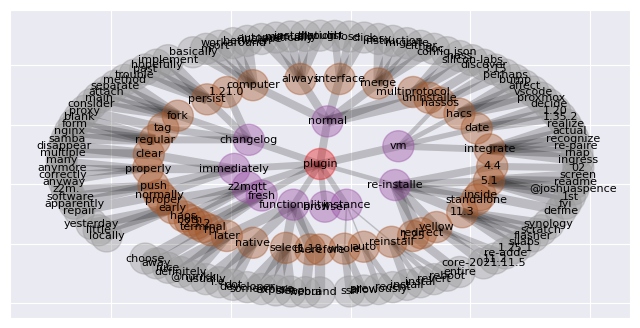

In [ ]:
model = models['zigbee2mqtt_w2v_sg_2']
graph = sim_tree(model, 'plugin', top_n=10, max_dist=3)
plot_tree(graph, node_size=500, font_size=8)